In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf
from sklearn.utils import class_weight 
import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
import tensorflow_text as text

from sklearn import metrics

import yaml

from matplotlib import pyplot as plt

import pydot

In [2]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [38]:
SEED  = configs['SEED']
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])
PATH_TO_IMAGES_MULTIMODAL  = str(configs['ROOT_DIR'] + configs['PATH_TO_IMAGES_MULTIMODAL'])
PATH_TO_MODELS  = str(configs['ROOT_DIR'] + configs['PATH_TO_MODELS'])

In [4]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
print(base.shape)
base.head()

(5453, 7)


,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [5]:
#I don't know why, but we have to convert all images from jpg/JPG to jpeg or png. I've choice jpeg :D
base.image_name = base.image_name.map(lambda x : x.replace('.jpg', '.jpeg').replace('.JPG','.jpeg'))
print(base.shape)
base.head()

(5453, 7)


,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpeg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [6]:
base['image_path'] = base.image_name.map(lambda x : PATH_TO_IMAGES_MULTIMODAL + x)
base.drop(columns=['humour', 'sarcasm','offensive','motivational', 'image_name'], inplace=True)
cols = base.columns.tolist()
cols = cols[-1:] + cols[:-1]
base = base[cols]
base.head()

,image_path,text,target
0,B:\utils\Documentos\MDC\projeto_final\meme-sen...,if you want to view paradis simpli look around...,positive
1,B:\utils\Documentos\MDC\projeto_final\meme-sen...,if i had a brick for everi lie hillari told i ...,positive
2,B:\utils\Documentos\MDC\projeto_final\meme-sen...,that thing over there can i eat that,very_positive
3,B:\utils\Documentos\MDC\projeto_final\meme-sen...,my dad point to liam and said when did david b...,neutral
4,B:\utils\Documentos\MDC\projeto_final\meme-sen...,probabl the first man to do year challeng chen...,negative


#### Considerando somente as labels 'negative', 'neutral' e 'positive'.

In [7]:
base.target.replace("very_positive", 
           "positive", 
           inplace=True)
base.target.replace("very_negative", 
           "negative", 
           inplace=True)    
NUM_LABELS = len(base.target.unique())
base.target = base.target.astype('category').cat.codes

base.head()

,image_path,text,target
0,B:\utils\Documentos\MDC\projeto_final\meme-sen...,if you want to view paradis simpli look around...,2
1,B:\utils\Documentos\MDC\projeto_final\meme-sen...,if i had a brick for everi lie hillari told i ...,2
2,B:\utils\Documentos\MDC\projeto_final\meme-sen...,that thing over there can i eat that,2
3,B:\utils\Documentos\MDC\projeto_final\meme-sen...,my dad point to liam and said when did david b...,1
4,B:\utils\Documentos\MDC\projeto_final\meme-sen...,probabl the first man to do year challeng chen...,0


In [8]:
train_df, val_df = train_test_split(base, test_size=0.2, random_state=SEED)
print(train_df.shape, val_df.shape)

(4362, 3) (1091, 3)


In [9]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train_df.target) ,y = train_df.target).ravel()
class_weights = dict((i,v) for i, v in enumerate(weights))
class_weights

{0: 3.5901234567901232, 1: 1.0699043414275202, 2: 0.5596612779060816}

# Multimodal

In [42]:
model_name = "multimodal"

In [10]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [11]:
def make_bert_preprocessing_model(sentence_features, seq_length=100):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model(["text"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [12]:
def dataframe_to_dataset(dataframe):
    columns = ["image_path", "text", "target"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [13]:
resize = (100, 100)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text):
    text = tf.convert_to_tensor([text])
    output = bert_preprocess_model([text])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["image_path"])
    text = preprocess_text(sample["text"])
    return {"image_path": image, "text": text}

In [14]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
#test_ds = prepare_dataset(test_df, False)

In [15]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [16]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    efficientNet = keras.applications.EfficientNetV2B0(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in efficientNet.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image = keras.Input(shape=(100, 100, 3), name="image")

    # Preprocess the input image.
    preprocessed = tf.keras.applications.efficientnet_v2.preprocess_input(image)

    # Generate the embeddings for the images using the EfficientNetV2B0 model
    # concatenate them.
    embedding = efficientNet(preprocessed)
    embeddings = keras.layers.Concatenate()([embedding])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image], outputs, name="vision_encoder")

In [17]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert")
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(100,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [18]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image = keras.Input(shape=(100, 100, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(100,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [19]:
class BalancedSparseCategoricalAccuracy(keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [28]:
early =  tf.keras.callbacks.EarlyStopping(monitor='balanced_sparse_categorical_accuracy', patience = 10, restore_best_weights=True)

multimodal_model.compile(
    optimizer="adam", 
    loss="sparse_categorical_crossentropy", 
    metrics = BalancedSparseCategoricalAccuracy()
)

multimodal_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 100)]        0           []                         

In [29]:
history = multimodal_model.fit(train_ds, 
                               validation_data=validation_ds, 
                               epochs = 100, 
                               class_weight = class_weights, 
                               callbacks=[early])

Epoch 1/100
137/137 [==============================] - 83s 542ms/step - loss: 0.8402 - balanced_sparse_categorical_accuracy: 0.5974 - val_loss: 1.3526 - val_balanced_sparse_categorical_accuracy: 0.3282
Epoch 2/100
137/137 [==============================] - 111s 817ms/step - loss: 0.7173 - balanced_sparse_categorical_accuracy: 0.6778 - val_loss: 1.3327 - val_balanced_sparse_categorical_accuracy: 0.3141
Epoch 3/100
137/137 [==============================] - 68s 498ms/step - loss: 0.6001 - balanced_sparse_categorical_accuracy: 0.7306 - val_loss: 1.3587 - val_balanced_sparse_categorical_accuracy: 0.3093
Epoch 4/100
137/137 [==============================] - 69s 503ms/step - loss: 0.5227 - balanced_sparse_categorical_accuracy: 0.7748 - val_loss: 1.5022 - val_balanced_sparse_categorical_accuracy: 0.3156
Epoch 5/100
137/137 [==============================] - 63s 459ms/step - loss: 0.4747 - balanced_sparse_categorical_accuracy: 0.8008 - val_loss: 1.7903 - val_balanced_sparse_categorical_accura

In [30]:
preds = multimodal_model.predict(validation_ds, verbose=3)
preds

array([[7.3487251e-07, 1.1536901e-01, 8.8463026e-01],
       [2.0420967e-01, 3.7259150e-03, 7.9206437e-01],
       [2.5594663e-03, 8.2148155e-03, 9.8922569e-01],
       ...,
       [2.7900508e-02, 1.2378237e-04, 9.7197568e-01],
       [2.5294371e-06, 1.0579881e-04, 9.9989164e-01],
       [4.9872726e-04, 1.7833136e-01, 8.2116991e-01]], dtype=float32)

In [31]:
prob = tf.nn.softmax(preds).numpy()
y_pred = np.argmax(prob, axis=1)

In [32]:
print("Val - balanced_accuracy : ", balanced_accuracy_score(val_df.target,  y_pred))
print("Val - F1 : ", f1_score(val_df.target, y_pred, average='macro'))

Val - balanced_accuracy :  0.330981279731796
Val - F1 :  0.32834855570189997


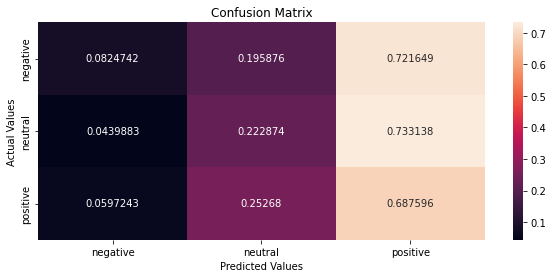

In [33]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(val_df.target, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

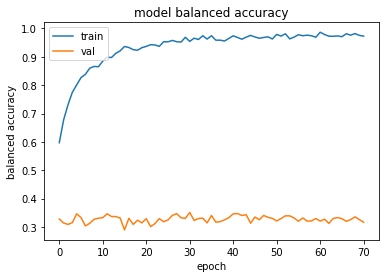

In [40]:
plt.plot(history.history['balanced_sparse_categorical_accuracy'])
plt.plot(history.history['val_balanced_sparse_categorical_accuracy'])
plt.title('model balanced accuracy')
plt.ylabel('balanced accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

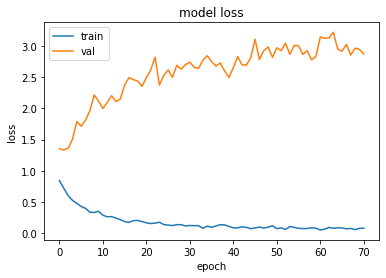

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
multimodal_model.save_weights(PATH_TO_MODELS + model_name)

'B:\\utils\\Documentos\\MDC\\projeto_final\\meme-sentiment-analysis/meme-sentiment-analysis/models/saved/models/multimodal'